In [ ]:
!pip install --upgrade torch torchvision torchaudio pytorch-lightning pytorch-forecasting
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-{{ torch.__version__.split('+')[0] }}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Install necessary packages
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install pytorch-forecasting
!pip install pytorch-lightning
!pip install memory_profiler


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
# Cell 2: Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Cell 3: Load data
def load_data(featured_data_path, dtw_adjacency_path, extracted_features_path, sample_size=None):
    """
    Load and prepare data for the hybrid model

    Args:
        featured_data_path: Path to the featured dataset CSV
        dtw_adjacency_path: Path to the DTW adjacency matrix CSV
        extracted_features_path: Path to the extracted features from TFT
        sample_size: Number of samples to use (None for all)

    Returns:
        featured_data: DataFrame with time series features
        adjacency_matrix: DTW adjacency matrix
        extracted_features: DataFrame with features extracted from TFT
    """
    print("Loading featured data...")
    featured_data = pd.read_csv(featured_data_path)

    if sample_size is not None:
        featured_data = featured_data.sample(sample_size, random_state=42)

    print("Loading DTW adjacency matrix...")
    adjacency_matrix = pd.read_csv(dtw_adjacency_path, index_col=0)

    print("Loading extracted features from TFT...")
    extracted_features = pd.read_csv(extracted_features_path)

    print("Data loading complete.")
    print(f"Featured data shape: {featured_data.shape}")
    print(f"Adjacency matrix shape: {adjacency_matrix.shape}")
    print(f"Extracted features shape: {extracted_features.shape}")

    return featured_data, adjacency_matrix, extracted_features

# Example usage
featured_data, adjacency_matrix, extracted_features = load_data(
    featured_data_path="/content/drive/MyDrive/WattGrid/data/processed/featured_data.csv",
    dtw_adjacency_path="/content/drive/MyDrive/WattGrid/data/processed/dtw_adjacency2_matrix.csv",
    extracted_features_path="/content/drive/MyDrive/WattGrid/extracted_features.csv",
    sample_size=1000000
)

Loading featured data...
Loading DTW adjacency matrix...
Loading extracted features from TFT...
Data loading complete.
Featured data shape: (1000000, 13)
Adjacency matrix shape: (246, 246)
Extracted features shape: (237, 10)


In [ ]:
# Cell 4: Data Preprocessing
def preprocess_data(featured_data, adjacency_matrix, extracted_features):
    """
    Preprocess the data for the hybrid model

    Args:
        featured_data: DataFrame with time series features
        adjacency_matrix: DTW adjacency matrix
        extracted_features: DataFrame with features extracted from TFT

    Returns:
        processed_data: Processed time series data
        edge_index: Tensor with edge indices for the graph
        edge_weight: Tensor with edge weights
        node_features: Tensor with static node features
        poc_mapping: Dictionary mapping POC names to indices
    """
    print("Preprocessing data...")

    # 1. Process time series data
    # Ensure data is sorted by POC and time
    featured_data = featured_data.sort_values(['PointOfConnection', 'TradingPeriod'])

    # Get unique POCs and create a mapping
    unique_pocs = featured_data['PointOfConnection'].unique()
    poc_to_idx = {poc: i for i, poc in enumerate(unique_pocs)}
    idx_to_poc = {i: poc for poc, i in poc_to_idx.items()}

    print(f"Found {len(unique_pocs)} unique points of connection")

    # 2. Create graph edge index and weights from adjacency matrix
    # Ensure adjacency matrix has the same POCs
    adj_matrix_pocs = list(adjacency_matrix.columns)
    common_pocs = list(set(unique_pocs).intersection(set(adj_matrix_pocs)))

    print(f"Common POCs between featured data and adjacency matrix: {len(common_pocs)}")

    # Filter adjacency matrix to only include common POCs
    adjacency_matrix = adjacency_matrix.loc[common_pocs, common_pocs]

    # Create edge index and weight for GAT
    edge_index = []
    edge_weight = []

    for i, poc_i in enumerate(common_pocs):
        for j, poc_j in enumerate(common_pocs):
            if i != j:  # Exclude self-loops
                similarity = adjacency_matrix.loc[poc_i, poc_j]
                # Convert similarity to a valid edge weight (higher similarity = stronger connection)
                weight = 1.0 - similarity  # Assuming DTW gives distance (lower = more similar)

                # Add edge if similarity is above threshold (optional)
                edge_index.append([poc_to_idx[poc_i], poc_to_idx[poc_j]])
                edge_weight.append(weight)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)

    print(f"Created graph with {edge_index.shape[1]} edges")

    # 3. Process node features from extracted TFT features
    if 'PointOfConnection' in extracted_features.columns:
        # If we have extracted features for each POC, use them as node features
        node_features_df = extracted_features.set_index('PointOfConnection')
        node_features = []

        for poc in common_pocs:
            if poc in node_features_df.index:
                node_features.append(node_features_df.loc[poc].values)
            else:
                # Use zeros for POCs without extracted features
                node_features.append(np.zeros(node_features_df.shape[1]))

        node_features = torch.tensor(np.array(node_features), dtype=torch.float)
    else:
        # If no extracted features, create simple node features based on POC statistics
        print("No extracted features found for POCs, creating statistical features")
        node_features_dict = {}

        for poc in common_pocs:
            poc_data = featured_data[featured_data['PointOfConnection'] == poc]

            if len(poc_data) > 0:
                # Create simple statistical features
                features = [
                    poc_data['DollarsPerMegawattHour'].mean(),
                    poc_data['DollarsPerMegawattHour'].std(),
                    poc_data['DollarsPerMegawattHour'].min(),
                    poc_data['DollarsPerMegawattHour'].max(),
                    poc_data['DollarsPerMegawattHour'].quantile(0.25),
                    poc_data['DollarsPerMegawattHour'].quantile(0.75)
                ]
                node_features_dict[poc] = features
            else:
                node_features_dict[poc] = [0.0] * 6

        # Convert to tensor
        node_features = torch.tensor([node_features_dict[poc] for poc in common_pocs], dtype=torch.float)

    print(f"Created node features with shape: {node_features.shape}")

    # Filter featured_data to only include common POCs
    processed_data = featured_data[featured_data['PointOfConnection'].isin(common_pocs)].copy()

    # Add node indices to the processed data
    processed_data['node_idx'] = processed_data['PointOfConnection'].map(poc_to_idx)

    print("Data preprocessing complete")

    return processed_data, edge_index, edge_weight, node_features, poc_to_idx

# Example usage
processed_data, edge_index, edge_weight, node_features, poc_mapping = preprocess_data(
    featured_data, adjacency_matrix, extracted_features
)

Preprocessing data...
Found 246 unique points of connection
Common POCs between featured data and adjacency matrix: 246
Created graph with 60270 edges
Created node features with shape: torch.Size([246, 9])
Data preprocessing complete


In [ ]:
# Cell 5: dataset for the hybrid model
class ElectricityPriceDataset(Dataset):
    def __init__(self, time_series_data, node_features, history_length, forecast_horizon,
                 time_features=None, target_col='DollarsPerMegawattHour'):
        """
        Dataset for electricity price forecasting with the hybrid model

        Args:
            time_series_data: DataFrame with time series features
            node_features: Tensor with static node features
            history_length: Number of historical time steps to use
            forecast_horizon: Number of future time steps to predict
            time_features: List of column names to use as time features (None for all numeric)
            target_col: Name of the target column
        """
        self.time_series_data = time_series_data
        self.node_features = node_features
        self.history_length = history_length
        self.forecast_horizon = forecast_horizon
        self.target_col = target_col

        # If no time features specified, use all numeric columns except target and node_idx
        if time_features is None:
            numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
            self.time_features = time_series_data.select_dtypes(include=numerics).columns.tolist()
            self.time_features = [f for f in self.time_features
                                 if f != 'node_idx' and f != self.target_col]
        else:
            self.time_features = time_features

        # Store the number of features for model configuration
        self.num_features = len(self.time_features)

        print(f"Using {len(self.time_features)} time features: {self.time_features[:5]}...")

        # Get unique POCs and time periods
        self.poc_ids = time_series_data['PointOfConnection'].unique()

        # Create valid prediction windows
        self.windows = self._create_windows()
        print(f"Created {len(self.windows)} valid windows for training/validation")

    def _create_windows(self):
        """Create valid windows for training/prediction"""
        windows = []

        for poc_id in self.poc_ids:
            poc_data = self.time_series_data[self.time_series_data['PointOfConnection'] == poc_id]

            if len(poc_data) <= self.history_length + self.forecast_horizon:
                continue

            # Get node index for this POC
            node_idx = poc_data['node_idx'].iloc[0]

            # Create sliding windows
            total_length = len(poc_data)
            for start_idx in range(0, total_length - self.history_length - self.forecast_horizon + 1):
                end_idx = start_idx + self.history_length
                windows.append((poc_id, node_idx, start_idx, end_idx))

        return windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        poc_id, node_idx, start_idx, end_idx = self.windows[idx]

        # Get time series data for this window
        poc_data = self.time_series_data[self.time_series_data['PointOfConnection'] == poc_id].iloc[start_idx:end_idx + self.forecast_horizon]

        if len(poc_data) < self.history_length + self.forecast_horizon:
            raise ValueError(f"Not enough data for window at index {idx}")

        # Split into history and future
        history_data = poc_data.iloc[:self.history_length]
        future_data = poc_data.iloc[self.history_length:self.history_length + self.forecast_horizon]

        # Create time features tensor
        time_features = history_data[self.time_features].values
        time_tensor = torch.tensor(time_features, dtype=torch.float)

        # Get static features for this POC
        static_tensor = self.node_features[node_idx]

        # Get target values for forecast horizon
        target_tensor = torch.tensor(future_data[self.target_col].values, dtype=torch.float)

        return time_tensor, static_tensor, target_tensor, torch.tensor(node_idx, dtype=torch.long)

# Function to create train/val/test splits
def create_data_loaders(processed_data, node_features, history_length=24,
                        forecast_horizon=12, batch_size=64, val_ratio=0.1,
                        test_ratio=0.1, time_features=None):
    """
    Create train, validation, and test data loaders

    Args:
        processed_data: Processed time series data
        node_features: Tensor with static node features
        history_length: Number of historical time steps to use
        forecast_horizon: Number of future time steps to predict
        batch_size: Batch size for data loaders
        val_ratio: Ratio of data to use for validation
        test_ratio: Ratio of data to use for testing
        time_features: List of column names to use as time features

    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
    """
    # Sort by time to ensure proper splitting
    processed_data = processed_data.sort_values('TradingPeriod')

    # Get unique timestamps
    timestamps = processed_data['TradingPeriod'].unique()
    n_timestamps = len(timestamps)

    # Calculate split indices
    test_idx = int(n_timestamps * (1 - test_ratio))
    val_idx = int(n_timestamps * (1 - test_ratio - val_ratio))

    # Split timestamps
    train_timestamps = timestamps[:val_idx]
    val_timestamps = timestamps[val_idx:test_idx]
    test_timestamps = timestamps[test_idx:]

    # Split data
    train_data = processed_data[processed_data['TradingPeriod'].isin(train_timestamps)]
    val_data = processed_data[processed_data['TradingPeriod'].isin(val_timestamps)]
    test_data = processed_data[processed_data['TradingPeriod'].isin(test_timestamps)]

    print(f"Train data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Create datasets
    train_dataset = ElectricityPriceDataset(
        train_data, node_features, history_length, forecast_horizon, time_features
    )

    val_dataset = ElectricityPriceDataset(
        val_data, node_features, history_length, forecast_horizon, time_features
    )

    test_dataset = ElectricityPriceDataset(
        test_data, node_features, history_length, forecast_horizon, time_features
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )

    return train_loader, val_loader, test_loader

# Example usage
train_loader, val_loader, test_loader = create_data_loaders(
    processed_data=processed_data,
    node_features=node_features,
    history_length=24,  # 24 hours
    forecast_horizon=12,  # 12 hours ahead
    batch_size=64
)


Train data shape: (833033, 14)
Validation data shape: (104481, 14)
Test data shape: (62486, 14)
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 824423 valid windows for training/validation
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 95871 valid windows for training/validation
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 53886 valid windows for training/validation


In [ ]:
# Cell 6: TFT Components
class GatedLinearUnit(nn.Module):
    def __init__(self, input_size, hidden_size=None, dropout=0.1):
        super().__init__()
        if hidden_size is None:
            hidden_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        sigmoid = torch.sigmoid(self.fc1(x))
        linear = self.fc2(x)
        return self.dropout(sigmoid * linear)

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        if output_size is None:
            output_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

        self.gate = GatedLinearUnit(output_size, dropout=dropout)

        # Skip connection
        self.skip_connection = nn.Linear(input_size, output_size) if input_size != output_size else nn.Identity()
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x, context=None):
        residual = self.skip_connection(x)

        output = self.fc1(x)
        output = self.elu(output)
        output = self.fc2(output)

        if context is not None:
            context_proj = self.context_proj(context)
            output += context_proj

        output = self.gate(output)
        output = output + residual
        output = self.norm(output)

        return output

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_sizes, hidden_size, dropout=0.1, context_size=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_sizes = input_sizes

        # GRN for variable selection weights
        if context_size is not None:
            self.weight_grn = GatedResidualNetwork(
                sum(input_sizes) + context_size, hidden_size, len(input_sizes), dropout
            )
        else:
            self.weight_grn = GatedResidualNetwork(
                sum(input_sizes), hidden_size, len(input_sizes), dropout
            )

        # GRN for each variable
        self.variable_grns = nn.ModuleDict()
        for i, size in enumerate(input_sizes):
            self.variable_grns[str(i)] = GatedResidualNetwork(
                size, hidden_size, hidden_size, dropout
            )

    def forward(self, x, context=None):
        # x shape: [batch_size, n_vars, var_dim]
        batch_size = x.size(0)
        flattened_input = x.reshape(batch_size, -1)

        # Get variable selection weights
        if context is not None:
            # Add context for weight computation
            weight_input = torch.cat([flattened_input, context], dim=1)
        else:
            weight_input = flattened_input

        weights = self.weight_grn(weight_input)
        weights = F.softmax(weights, dim=-1).unsqueeze(-1)  # [batch_size, n_vars, 1]

        # Process each variable with its own GRN
        var_outputs = []
        for i, size in enumerate(self.input_sizes):
            var_outputs.append(
                self.variable_grns[str(i)](x[:, i])
            )

        var_outputs = torch.stack(var_outputs, dim=1)  # [batch_size, n_vars, hidden_size]

        # Weight and combine variable outputs
        outputs = (weights * var_outputs).sum(dim=1)  # [batch_size, hidden_size]

        return outputs, weights

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=4, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # Project queries, keys, values
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Project queries, keys, values
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Reshape for multi-head attention
        q = q.view(batch_size, -1, self.num_heads, self.hidden_size // self.num_heads).transpose(1, 2)
        k = k.view(batch_size, -1, self.num_heads, self.hidden_size // self.num_heads).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, self.hidden_size // self.num_heads).transpose(1, 2)

        # Calculate attention scores
        scores = torch.matmul(q, k.transpose(-1, -2)) / (self.hidden_size // self.num_heads) ** 0.5

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Calculate attention weights
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)

        # Reshape back
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)

        # Final projection
        output = self.out_proj(context)

        return output, attn_weights

In [ ]:
# Cell 7: Hybrid TFT+GAT model
class TFT_GAT_Hybrid(nn.Module):
    def __init__(
        self,
        # Graph parameters
        in_node_features,
        hidden_graph_size,
        graph_heads,
        # Time series parameters
        num_time_features,
        hidden_temporal_size,
        lstm_layers,
        # Fusion parameters
        fusion_size,
        # Output parameters
        horizon,
        quantiles=[0.1, 0.5, 0.9],
        dropout=0.1
    ):
        super().__init__()
        self.horizon = horizon
        self.quantiles = quantiles
        self.hidden_temporal_size = hidden_temporal_size
        self.num_time_features = num_time_features

        # 1. Graph Attention Component
        self.gat1 = GATConv(in_node_features, hidden_graph_size, heads=graph_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_graph_size * graph_heads, hidden_graph_size, heads=1, dropout=dropout)
        self.gat_norm = nn.LayerNorm(hidden_graph_size)

        # 2. Temporal Component - Feature Projection
        # Instead of VSN, use a simpler feature projection approach
        self.feature_projection = nn.Sequential(
            nn.Linear(num_time_features, hidden_temporal_size),
            nn.LayerNorm(hidden_temporal_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 3. Temporal Component - Encoder
        self.encoder_lstm = nn.LSTM(
            input_size=hidden_temporal_size,
            hidden_size=hidden_temporal_size,
            num_layers=lstm_layers,
            dropout=dropout if lstm_layers > 1 else 0,
            batch_first=True
        )

        # 4. Temporal Attention
        self.temporal_attn = InterpretableMultiHeadAttention(
            hidden_size=hidden_temporal_size,
            num_heads=4,
            dropout=dropout
        )

        # 5. Spatio-Temporal Fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_temporal_size + hidden_graph_size, fusion_size),
            nn.LayerNorm(fusion_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_size, fusion_size)
        )

        # 6. Decoder
        self.decoder_lstm = nn.LSTM(
            input_size=fusion_size,
            hidden_size=fusion_size,
            num_layers=lstm_layers,
            dropout=dropout if lstm_layers > 1 else 0,
            batch_first=True
        )

        # 7. Output Layer - Fix the output size calculation
        self.output_layer = nn.Linear(fusion_size, len(quantiles))

    def forward(self, x_time, edge_index, edge_weight, static_features, node_indices):
        batch_size = x_time.size(0)
        seq_len = x_time.size(1)

        # Process graph structure for all nodes
        # Apply GAT layers to all nodes at once
        x_graph = static_features  # Shape: [num_nodes, in_node_features]

        # First GAT layer
        x_graph = self.gat1(x_graph, edge_index, edge_weight)
        x_graph = F.relu(x_graph)
        x_graph = F.dropout(x_graph, p=0.2, training=self.training)

        # Second GAT layer
        x_graph = self.gat2(x_graph, edge_index, edge_weight)
        x_graph = self.gat_norm(x_graph)  # Shape: [num_nodes, hidden_graph_size]

        # Process temporal data - apply feature projection to each time step
        # First reshape to [batch_size * seq_len, num_features]
        x_time_flat = x_time.reshape(batch_size * seq_len, -1)

        # Apply feature projection
        x_projected = self.feature_projection(x_time_flat)

        # Reshape back to sequence form [batch_size, seq_len, hidden_size]
        x_projected = x_projected.view(batch_size, seq_len, self.hidden_temporal_size)

        # Calculate variable importance (use the first layer's weights as a proxy)
        with torch.no_grad():
            var_weights = self.feature_projection[0].weight.sum(dim=0)
            var_weights = F.softmax(var_weights, dim=0).unsqueeze(0).repeat(batch_size, 1)

        # LSTM Encoder
        encoder_output, (h_n, c_n) = self.encoder_lstm(x_projected)

        # Apply temporal attention
        temporal_context, temporal_weights = self.temporal_attn(
            q=encoder_output[:, -1:, :],  # Use last time step as query
            k=encoder_output,
            v=encoder_output
        )
        temporal_context = temporal_context.squeeze(1)  # Shape: [batch_size, hidden_temporal_size]

        # Get graph embeddings for each node in the batch
        # Use node_indices to select the appropriate graph embedding for each sample
        node_graph_embeds = x_graph[node_indices]  # Shape: [batch_size, hidden_graph_size]

        # Concatenate temporal and graph information
        combined = torch.cat([temporal_context, node_graph_embeds], dim=1)
        fused = self.fusion(combined)  # Shape: [batch_size, fusion_size]

        # Prepare decoder input (repeat fused info for each forecast step)
        decoder_input = fused.unsqueeze(1).repeat(1, self.horizon, 1)

        # Decode to get forecast
        decoder_output, _ = self.decoder_lstm(decoder_input)

        # Final prediction layer - apply to each time step
        # Shape: [batch_size, horizon, hidden_size] -> [batch_size, horizon, num_quantiles]
        output = self.output_layer(decoder_output)

        return output, temporal_weights, var_weights, x_graph

In [ ]:
# Cell 8: Training function
def train_hybrid_model(model, train_loader, val_loader, edge_index, edge_weight, static_features,
                       epochs=100, lr=0.001, patience=10, device="cuda"):
    """
    Train the hybrid TFT-GAT model
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience//2, verbose=True
    )

    # Quantile loss function
    def quantile_loss(y_pred, y_true, quantiles):
        losses = []
        for i, q in enumerate(quantiles):
            errors = y_true - y_pred[..., i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(-1))
        return torch.mean(torch.cat(losses, dim=-1))

    # Move graph data to device
    edge_index = edge_index.to(device)
    edge_weight = edge_weight.to(device) if edge_weight is not None else None
    static_features = static_features.to(device)

    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_state = None

    # Track metrics
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch_idx, (x_time, static_feature_indices, targets, node_indices) in enumerate(progress_bar):
            x_time = x_time.to(device)
            static_feature_indices = static_feature_indices.to(device)
            targets = targets.to(device)
            node_indices = node_indices.to(device)

            optimizer.zero_grad()
            predictions, _, _, _ = model(x_time, edge_index, edge_weight, static_features, node_indices)
            loss = quantile_loss(predictions, targets, model.quantiles)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for x_time, static_feature_indices, targets, node_indices in progress_bar:
                x_time = x_time.to(device)
                static_feature_indices = static_feature_indices.to(device)
                targets = targets.to(device)
                node_indices = node_indices.to(device)

                predictions, _, _, _ = model(x_time, edge_index, edge_weight, static_features, node_indices)
                loss = quantile_loss(predictions, targets, model.quantiles)
                val_loss += loss.item()
                progress_bar.set_postfix({"loss": loss.item()})

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Learning rate scheduler
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, {'train_losses': train_losses, 'val_losses': val_losses}

In [ ]:
# Cell 9: Evaluation function
def evaluate_model(model, test_loader, edge_index, edge_weight, static_features, device="cuda"):
    """
    Evaluate the hybrid model on test data
    """
    model.to(device)
    model.eval()

    predictions = []
    actual_values = []
    node_ids = []

    with torch.no_grad():
        for x_time, static_feature_indices, targets, node_indices in tqdm(test_loader, desc="Evaluating"):
            x_time = x_time.to(device)
            static_feature_indices = static_feature_indices.to(device)
            targets = targets.to(device)
            node_indices = node_indices.to(device)

            pred, _, _, _ = model(x_time, edge_index, edge_weight, static_features, node_indices)

            # Store predictions and actual values
            predictions.append(pred.cpu().numpy())
            actual_values.append(targets.cpu().numpy())
            node_ids.append(node_indices.cpu().numpy())

    # Concatenate results
    predictions = np.concatenate(predictions, axis=0)
    actual_values = np.concatenate(actual_values, axis=0)
    node_ids = np.concatenate(node_ids, axis=0)

    # Calculate metrics
    # Use median (quantile 0.5) for point predictions
    median_idx = model.quantiles.index(0.5) if 0.5 in model.quantiles else 0
    point_predictions = predictions[:, :, median_idx]

    # Calculate MAE and RMSE
    mae = np.mean(np.abs(point_predictions - actual_values))
    rmse = np.sqrt(np.mean((point_predictions - actual_values) ** 2))

    # Calculate MAPE
    mape = np.mean(np.abs((actual_values - point_predictions) / (actual_values + 1e-8))) * 100

    # Calculate quantile losses
    q_losses = []
    for i, q in enumerate(model.quantiles):
        errors = actual_values - predictions[:, :, i]
        q_loss = np.mean(np.maximum((q-1) * errors, q * errors))
        q_losses.append(q_loss)

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Quantile Losses': {q: loss for q, loss in zip(model.quantiles, q_losses)}
    }

    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAPE: {mape:.4f}%")
    for q, loss in zip(model.quantiles, q_losses):
        print(f"Test Quantile Loss (q={q}): {loss:.4f}")

    return metrics, predictions, actual_values, node_ids

In [ ]:
# Cell 10: Visualization functions
def plot_forecast_sample(predictions, actual_values, node_ids, idx, model, poc_mapping=None):
    """
    Plot a sample forecast
    """
    horizon = predictions.shape[1]
    quantiles = model.quantiles

    # Get the node ID
    node_id = node_ids[idx]

    # Get POC name if mapping is provided
    if poc_mapping is not None:
        inv_mapping = {v: k for k, v in poc_mapping.items()}
        poc_name = inv_mapping.get(node_id, f"Node {node_id}")
    else:
        poc_name = f"Node {node_id}"

    # Get actual values and predictions for this sample
    actuals = actual_values[idx]
    preds = predictions[idx]

    # Create x-axis for horizon
    x = np.arange(horizon)

    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(x, actuals, 'ko-', label='Actual', linewidth=2)

    # Find median quantile index
    median_idx = quantiles.index(0.5) if 0.5 in quantiles else len(quantiles) // 2

    # Plot median prediction
    plt.plot(x, preds[:, median_idx], 'b-', label=f'Median Forecast (q={quantiles[median_idx]})', linewidth=2)

    # Plot quantile intervals
    for i, q in enumerate(quantiles):
        if i != median_idx:
            plt.plot(x, preds[:, i], 'b--', alpha=0.5, linewidth=1)

    # Fill between upper and lower quantiles if available
    if len(quantiles) >= 3:
        lower_idx = 0  # Typically the lowest quantile
        upper_idx = len(quantiles) - 1  # Typically the highest quantile
        plt.fill_between(x, preds[:, lower_idx], preds[:, upper_idx],
                        color='blue', alpha=0.2,
                        label=f'Prediction Interval (q={quantiles[lower_idx]}-{quantiles[upper_idx]})')

    plt.title(f'Forecast for {poc_name}')
    plt.xlabel('Horizon')
    plt.ylabel('Price ($/MWh)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_attention_weights(temporal_weights, node_id, time_steps, title="Temporal Attention Weights"):
    """
    Visualize attention weights
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(temporal_weights[node_id].cpu().numpy(), cmap='viridis')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Attention Heads')
    plt.show()

def plot_variable_importance(var_weights, feature_names, title="Variable Importance"):
    """
    Plot variable importance from VSN weights
    """
    # Average weights across samples
    avg_weights = var_weights.mean(0).cpu().numpy()

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(avg_weights)), avg_weights)
    plt.xticks(range(len(avg_weights)), feature_names, rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

def visualize_graph_embeddings(node_embeddings, node_ids, poc_mapping=None, n_components=2):
    """
    Visualize graph node embeddings using PCA
    """
    from sklearn.decomposition import PCA

    # Get embeddings for the nodes
    embeddings = node_embeddings.cpu().numpy()

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create POC labels if mapping is provided
    if poc_mapping is not None:
        inv_mapping = {v: k for k, v in poc_mapping.items()}
        labels = [inv_mapping.get(node_id, f"Node {node_id}") for node_id in range(len(embeddings))]
    else:
        labels = [f"Node {i}" for i in range(len(embeddings))]

    # Plot in 2D
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                         c=np.arange(len(embeddings)), cmap='tab20', s=100, alpha=0.8)

    # Add labels for a subset of nodes to avoid overcrowding
    max_labels = min(20, len(embeddings))
    indices = np.linspace(0, len(embeddings)-1, max_labels, dtype=int)

    for i in indices:
        plt.annotate(labels[i], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                    fontsize=8, ha='right', va='bottom')

    plt.title('Graph Node Embeddings (PCA)')
    plt.colorbar(scatter, label='Node Index')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Loading featured data...
Loading DTW adjacency matrix...
Loading extracted features from TFT...
Data loading complete.
Featured data shape: (100000, 13)
Adjacency matrix shape: (246, 246)
Extracted features shape: (237, 10)
Preprocessing data...
Found 246 unique points of connection
Common POCs between featured data and adjacency matrix: 246
Created graph with 60270 edges
Created node features with shape: torch.Size([246, 9])
Data preprocessing complete
Train data shape: (83304, 14)
Validation data shape: (10404, 14)
Test data shape: (6292, 14)
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 74698 valid windows for training/validation
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 2016 valid windows for training/validation
Using 6 time features: ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7']...
Created 26 valid windows for training/validation
Number of ti

Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, loss=68.5]


Epoch 1/10, Train Loss: 57.866511, Val Loss: 58.774531


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, loss=51.3]


Epoch 2/10, Train Loss: 41.015128, Val Loss: 42.436414


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, loss=45.5]


Epoch 3/10, Train Loss: 33.825547, Val Loss: 36.673264


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, loss=43.1]


Epoch 4/10, Train Loss: 31.477239, Val Loss: 34.134543


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, loss=42.3]


Epoch 5/10, Train Loss: 30.614000, Val Loss: 33.212669


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, loss=42]


Epoch 6/10, Train Loss: 30.433189, Val Loss: 33.005189


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, loss=41.9]


Epoch 7/10, Train Loss: 30.414524, Val Loss: 32.954445


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s, loss=41.9]


Epoch 8/10, Train Loss: 30.413073, Val Loss: 32.939950


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, loss=41.9]


Epoch 9/10, Train Loss: 30.414119, Val Loss: 32.968719


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s, loss=41.9]


Epoch 10/10, Train Loss: 30.413249, Val Loss: 32.968211


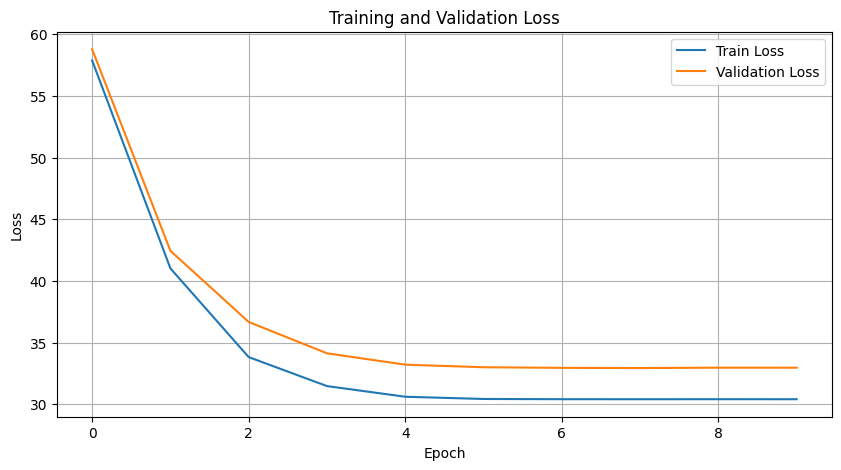

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Test MAE: 86.5632
Test RMSE: 117.7603
Test MAPE: 25651.0345%
Test Quantile Loss (q=0.1): 13.6447
Test Quantile Loss (q=0.5): 43.2816
Test Quantile Loss (q=0.9): 23.1675


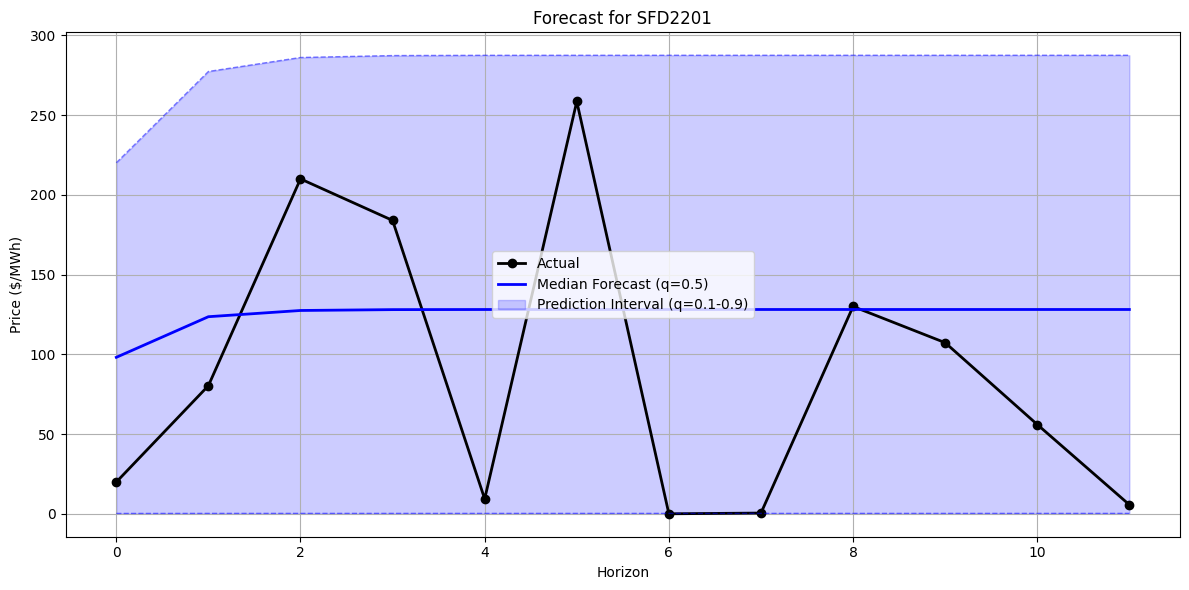

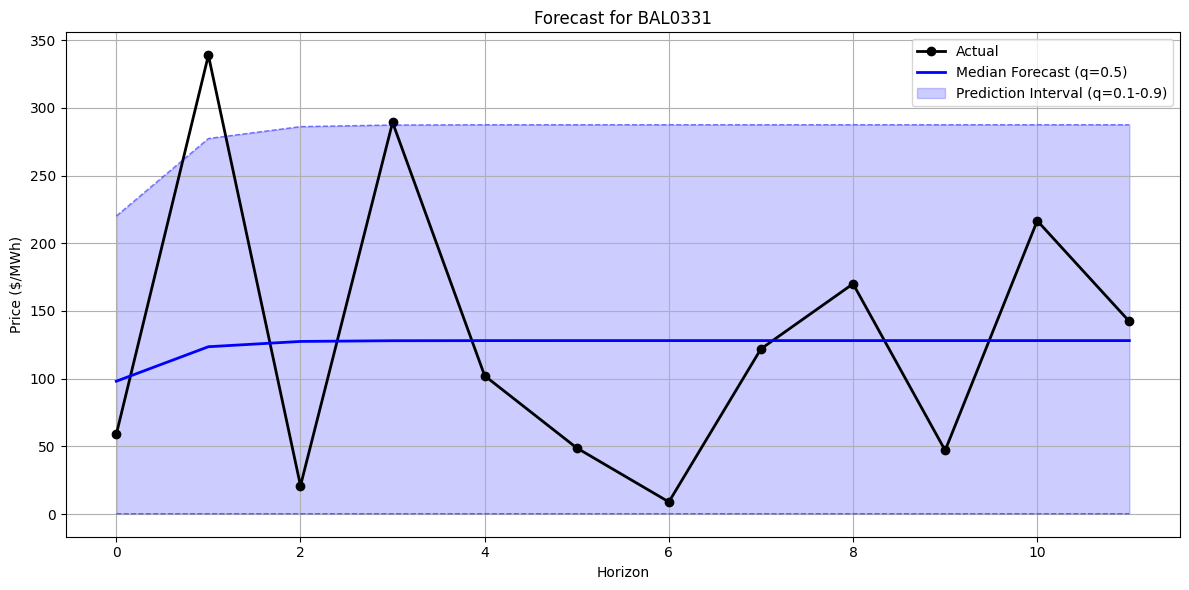

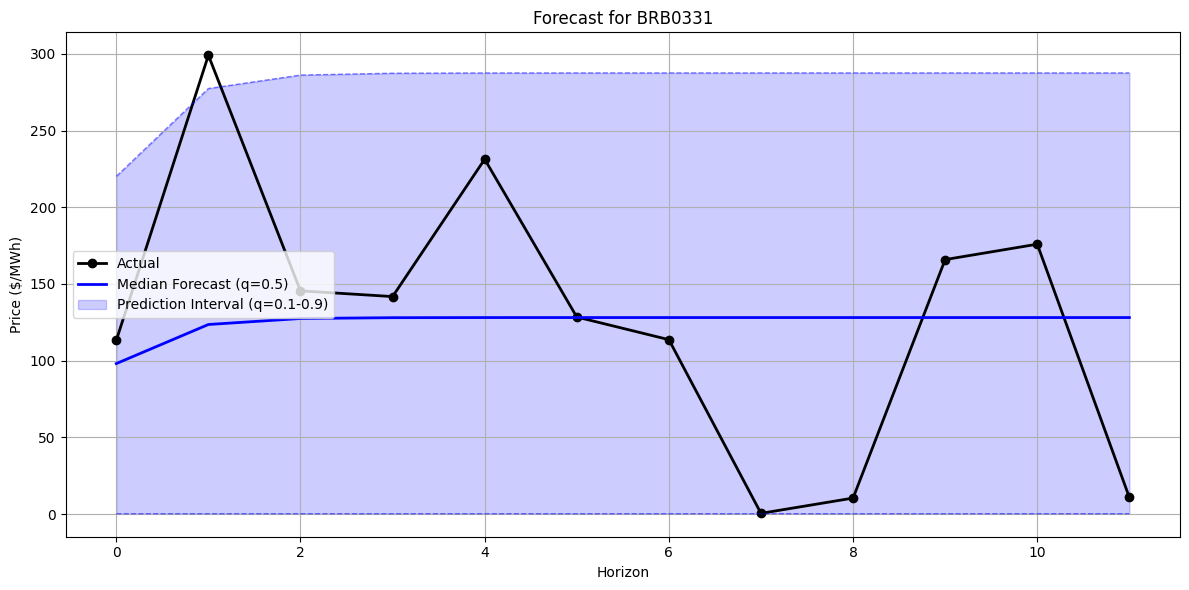

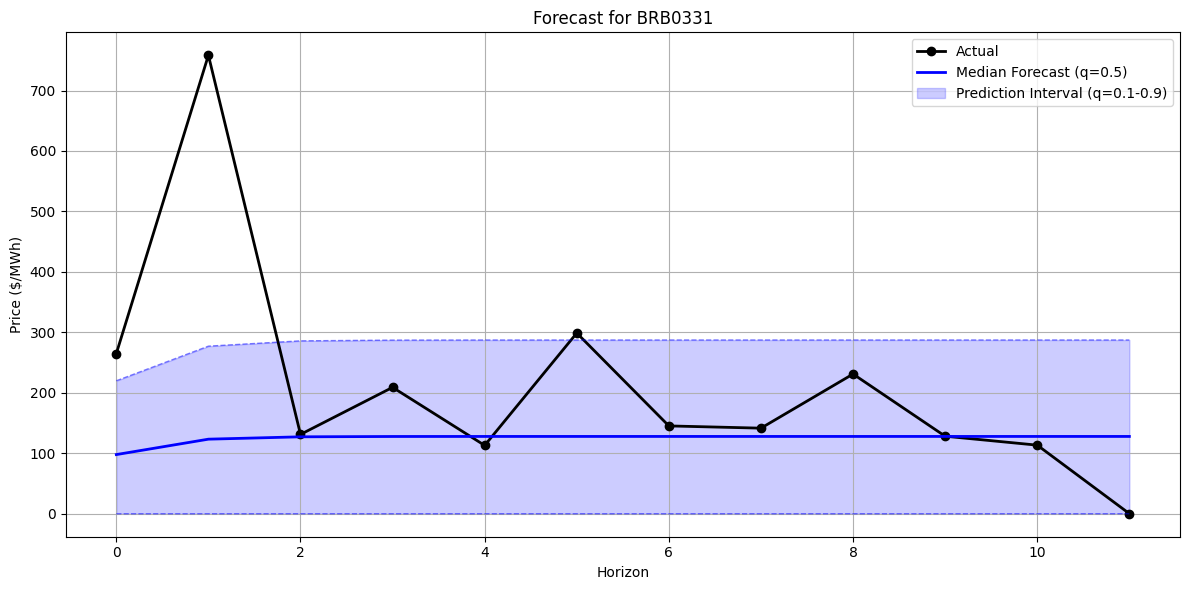

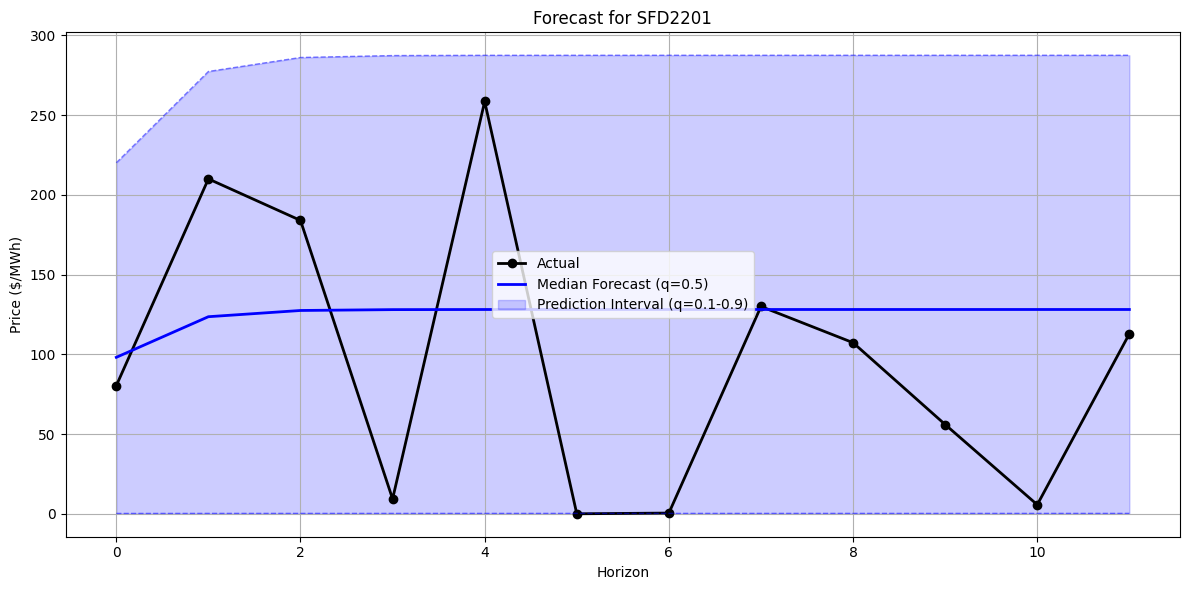

Model saved successfully


In [ ]:
def main():
    """
    Main execution function
    """
    # 1. Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # 2. Load and preprocess data
    featured_data, adjacency_matrix, extracted_features = load_data(
        featured_data_path="/content/drive/MyDrive/WattGrid/data/processed/featured_data.csv",
        dtw_adjacency_path="/content/drive/MyDrive/WattGrid/data/processed/dtw_adjacency2_matrix.csv",
        extracted_features_path="/content/drive/MyDrive/WattGrid/extracted_features.csv",
        sample_size=100000  # Using a smaller sample for demonstration
    )

    # 3. Preprocess data
    processed_data, edge_index, edge_weight, node_features, poc_mapping = preprocess_data(
        featured_data, adjacency_matrix, extracted_features
    )

    # 4. Create data loaders with specific time features to avoid dimensionality issues
    time_features = ['TradingPeriod', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7', 'DollarsPerMegawattHour']
    train_loader, val_loader, test_loader = create_data_loaders(
        processed_data=processed_data,
        node_features=node_features,
        history_length=24,  # 24 hours of history
        forecast_horizon=12,  # 12 hours ahead
        batch_size=64,
        time_features=time_features
    )

    # Get the number of time features used
    num_features = len(time_features)
    print(f"Number of time features: {num_features}")

    # 5. Initialize model with the correct number of features
    model = TFT_GAT_Hybrid(
        # Graph parameters
        in_node_features=node_features.shape[1],
        hidden_graph_size=64,
        graph_heads=4,
        # Time series parameters
        num_time_features=num_features,  # Use the exact number of features
        hidden_temporal_size=64,
        lstm_layers=2,
        # Fusion parameters
        fusion_size=64,
        # Output parameters
        horizon=12,
        quantiles=[0.1, 0.5, 0.9],
        dropout=0.1
    )

    # 6. Train model
    model, training_history = train_hybrid_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        edge_index=edge_index,
        edge_weight=edge_weight,
        static_features=node_features,
        epochs=10,
        lr=0.001,
        patience=10,
        device=device
    )

    # 7. Evaluate model
    metrics, predictions, actual_values, node_ids = evaluate_model(
        model=model,
        test_loader=test_loader,
        edge_index=edge_index,
        edge_weight=edge_weight,
        static_features=node_features,
        device=device
    )

    # 8. Visualize results
    # Plot sample forecasts
    for i in range(5):  # Plot 5 random samples
        idx = np.random.randint(0, len(predictions))
        plot_forecast_sample(predictions, actual_values, node_ids, idx, model, poc_mapping)

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'metrics': metrics,
        'training_history': training_history
    }, '/content/drive/MyDrive/WattGrid/hybrid_tft_gat_model.pth')

    print("Model saved successfully")

# Uncomment to run the main function
if __name__ == "__main__":
    main()

In [ ]:
# Cell 12: Load a pre-trained TFT model and integrate with GAT
def load_pretrained_tft_and_create_hybrid(tft_model_path, node_features, edge_index, edge_weight):
    """
    Load a pre-trained TFT model and create a hybrid with GAT
    """
    # Load the pre-trained TFT model
    print(f"Loading pre-trained TFT model from {tft_model_path}")
    tft_model = torch.load(tft_model_path, map_location=device)

    # Extract relevant parameters and weights
    tft_state_dict = tft_model['state_dict'] if 'state_dict' in tft_model else tft_model

    # Initialize the hybrid model
    hybrid_model = TFT_GAT_Hybrid(
        # Graph parameters
        in_node_features=node_features.shape[1],
        hidden_graph_size=64,
        graph_heads=4,
        # Time series parameters - match with TFT
        num_time_features=64,  # Adjust based on your TFT model
        hidden_temporal_size=64,  # Match with TFT hidden size
        lstm_layers=2,
        # Fusion parameters
        fusion_size=64,
        # Output parameters
        horizon=12,  # Match with TFT
        quantiles=[0.1, 0.5, 0.9],  # Match with TFT
        dropout=0.1
    )

    # Get state dictionaries
    hybrid_state_dict = hybrid_model.state_dict()

    # Print model architectures if in debug mode
    print_debug = False
    if print_debug:
        print("\nTFT model state dict keys:")
        for key in tft_state_dict.keys():
            print(f"  {key}")

        print("\nHybrid model state dict keys:")
        for key in hybrid_state_dict.keys():
            print(f"  {key}")

    # Define mapping between TFT and hybrid model components
    # This mapping will need to be adjusted based on your specific TFT model structure
    mapping = {
        # Encoder LSTM mappings
        'lstm_encoder.weight_ih_l0': 'encoder_lstm.weight_ih_l0',
        'lstm_encoder.weight_hh_l0': 'encoder_lstm.weight_hh_l0',
        'lstm_encoder.bias_ih_l0': 'encoder_lstm.bias_ih_l0',
        'lstm_encoder.bias_hh_l0': 'encoder_lstm.bias_hh_l0',
        'lstm_encoder.weight_ih_l1': 'encoder_lstm.weight_ih_l1',
        'lstm_encoder.weight_hh_l1': 'encoder_lstm.weight_hh_l1',
        'lstm_encoder.bias_ih_l1': 'encoder_lstm.bias_ih_l1',
        'lstm_encoder.bias_hh_l1': 'encoder_lstm.bias_hh_l1',

        # Decoder LSTM mappings
        'lstm_decoder.weight_ih_l0': 'decoder_lstm.weight_ih_l0',
        'lstm_decoder.weight_hh_l0': 'decoder_lstm.weight_hh_l0',
        'lstm_decoder.bias_ih_l0': 'decoder_lstm.bias_ih_l0',
        'lstm_decoder.bias_hh_l0': 'decoder_lstm.bias_hh_l0',
        'lstm_decoder.weight_ih_l1': 'decoder_lstm.weight_ih_l1',
        'lstm_decoder.weight_hh_l1': 'decoder_lstm.weight_hh_l1',
        'lstm_decoder.bias_ih_l1': 'decoder_lstm.bias_ih_l1',
        'lstm_decoder.bias_hh_l1': 'decoder_lstm.bias_hh_l1',

        # Attention mechanism mappings
        'multihead_attn.q_proj.weight': 'temporal_attn.q_proj.weight',
        'multihead_attn.q_proj.bias': 'temporal_attn.q_proj.bias',
        'multihead_attn.k_proj.weight': 'temporal_attn.k_proj.weight',
        'multihead_attn.k_proj.bias': 'temporal_attn.k_proj.bias',
        'multihead_attn.v_proj.weight': 'temporal_attn.v_proj.weight',
        'multihead_attn.v_proj.bias': 'temporal_attn.v_proj.bias',
        'multihead_attn.out_proj.weight': 'temporal_attn.out_proj.weight',
        'multihead_attn.out_proj.bias': 'temporal_attn.out_proj.bias',

        # Feature projection mappings - if your feature projection structure matches
        'feature_proj.0.weight': 'feature_projection.0.weight',
        'feature_proj.0.bias': 'feature_projection.0.bias',
        'feature_proj.2.weight': 'feature_projection.2.weight',
        'feature_proj.2.bias': 'feature_projection.2.bias',

        # Output layer mapping
        'output_layer.weight': 'output_layer.weight',
        'output_layer.bias': 'output_layer.bias',
    }

    # For PyTorch Forecasting TFT model, the keys might have prefixes
    # These are common prefixes in PyTorch Forecasting
    prefixes = [
        '',
        'model.',
        'model.model.',
        'model.network.',
        'network.',
        'temporal_fusion_transformer.'
    ]

    # Try to transfer weights with different prefix combinations
    transferred_params = set()
    transfer_count = 0

    for tft_key_base, hybrid_key in mapping.items():
        transferred = False

        # Try different prefix combinations
        for prefix in prefixes:
            tft_key = prefix + tft_key_base

            if tft_key in tft_state_dict and hybrid_key in hybrid_state_dict:
                # Check if shapes match
                if tft_state_dict[tft_key].shape == hybrid_state_dict[hybrid_key].shape:
                    hybrid_state_dict[hybrid_key] = tft_state_dict[tft_key]
                    transferred_params.add(hybrid_key)
                    transfer_count += 1
                    transferred = True
                    print(f"Transferred weights: {tft_key} -> {hybrid_key}, shape: {tft_state_dict[tft_key].shape}")
                    break
                else:
                    print(f"Shape mismatch: {tft_key} {tft_state_dict[tft_key].shape} vs {hybrid_key} {hybrid_state_dict[hybrid_key].shape}")

        if not transferred:
            print(f"Could not transfer weights for {hybrid_key} - no matching parameter found in TFT model")

    # Load the partial state dict into the hybrid model
    hybrid_model.load_state_dict(hybrid_state_dict, strict=False)
    print(f"Transferred weights for {transfer_count} parameters")

    # Move model to the appropriate device
    hybrid_model = hybrid_model.to(device)

    return hybrid_model

# Example usage
hybrid_model = load_pretrained_tft_and_create_hybrid(
    tft_model_path="/content/drive/MyDrive/WattGrid/tft_model_1M.pth",
    node_features=node_features,
    edge_index=edge_index,
    edge_weight=edge_weight
)

Loading pre-trained TFT model from /content/drive/MyDrive/WattGrid/tft_model_1M.pth
Shape mismatch: lstm_encoder.weight_ih_l0 torch.Size([64, 16]) vs encoder_lstm.weight_ih_l0 torch.Size([256, 64])
Could not transfer weights for encoder_lstm.weight_ih_l0 - no matching parameter found in TFT model
Shape mismatch: lstm_encoder.weight_hh_l0 torch.Size([64, 16]) vs encoder_lstm.weight_hh_l0 torch.Size([256, 64])
Could not transfer weights for encoder_lstm.weight_hh_l0 - no matching parameter found in TFT model
Shape mismatch: lstm_encoder.bias_ih_l0 torch.Size([64]) vs encoder_lstm.bias_ih_l0 torch.Size([256])
Could not transfer weights for encoder_lstm.bias_ih_l0 - no matching parameter found in TFT model
Shape mismatch: lstm_encoder.bias_hh_l0 torch.Size([64]) vs encoder_lstm.bias_hh_l0 torch.Size([256])
Could not transfer weights for encoder_lstm.bias_hh_l0 - no matching parameter found in TFT model
Could not transfer weights for encoder_lstm.weight_ih_l1 - no matching parameter found i